# Example of using the orm classes

### Imports

In [44]:
from core.core import Project
from core.orm import BoreholeOrm, Base
from striplog import Lexicon, Striplog, Interval, Component, Position, Decor, Legend
from striplog.utils import hex_to_rgb
from matplotlib.colors import ListedColormap
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [45]:
import re
import numpy as np
import matplotlib.pyplot as plt
import omfvista as ov
import pyvista as pv
import omf
from vtk import vtkX3DExporter
from IPython.display import HTML

In [46]:
! rm ./tmp/test_orm_db.db

In [47]:
def striplog_legend_to_omf_legend(legend):
    omf_legend=[]
    newcolors = [np.array([0.9, 0.9, 0.9, 1.])]
    for i in legend:
        omf_legend.append(i.colour)
        newcolors.append(np.hstack([np.array(hex_to_rgb(i.colour))/255, np.array([1.])]))
    return omf.data.Legend(description='', name='', values=omf.data.ColorArray(omf_legend)), ListedColormap(newcolors)

In [48]:
components = [Component({'lithology': 'siltstone', 'colour': 'grey'}),
              Component({'lithology': 'anhydrite'}),
              Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'grey'}),
              Component({'lithology': 'dolomite'}),
              Component({'lithology': 'siltstone', 'colour': 'red'}),
              Component({'lithology': 'limestone'})]
list_of_decors=[]
hatches = ['=', 'x', '.', 's', '=', 'b']
colours = ['#888888', '#882222', '#AAAAAA', '#CC22CC', '#CC2222', '#2222CC']
for i in range(len(components)):
    d = {'color': colours[i],
         'hatch': hatches[i],
         'component': components[i],
         'width': 3}
    decor = Decor(d)
    list_of_decors.append(decor)
legend = Legend(list_of_decors)

In [49]:
omf_legend, omf_cmap = striplog_legend_to_omf_legend(legend)

### Define the Borehole class

In [50]:
class Borehole3D(Striplog):
    #-------------------------------Docstring--------------------------------------------
    """
        
    """
    
    #------------------------------ Properties -------------------------------------------
    def __init__ (self, intervals=None, name='', legend=None, x_collar=0., y_collar=0.):
        self.name = name

        if legend is None or not isinstance(legend, Legend):
            self.legend = Legend.default()
        else:
            self.legend = legend
            
        self.x_collar = x_collar
        self.y_collar = y_collar
        self.omf_legend, self.omf_cmap = striplog_legend_to_omf_legend(self.legend)
            
        if intervals is None:
            lexicon=Lexicon.default()
            with open('../data/test.las', 'r') as las3:
                default_intv=Striplog.from_las3(las3.read(), lexicon)
                intervals = list(default_intv)
            print("Pay attention that default intervals are actually used !\n")
        self.intervals = intervals
        self.geometry = []
        
        # instanciation with supers properties
        Striplog.__init__(self, list_of_Intervals=self.intervals)
        
        #self.uid=uuid #get a unique for identification of borehole in the project

        self.build_geometry()
        
    def get_components_indices(self):
        indices = []
        for i in self.intervals:
            if i.components[0] in self.components:
                indices.append(self.components.index(i.components[0]))
            else:
                indices.append(-1)
        return np.array(indices)
    
    def build_geometry(self):
    
        vertices, segments = [], []
        
        for i in self.intervals:
            if i.top not in vertices:
                if hasattr(i.top, 'x') and hasattr(i.top, 'y'):
                    x = i.top.x
                    y = i.top.y
                else:
                    x = self.x_collar
                    y = self.y_collar
                vertices.append([x, y, -i.top.z])
                top = len(vertices)-1
            else:
                top = vertices.index(i.top)
            if i.base not in vertices:
                if hasattr(i.base, 'x') and hasattr(i.base, 'y'):
                    x = i.base.x
                    y = i.base.y
                else:
                    x = self.x_collar
                    y = self.y_collar
                vertices.append([x, y, -i.base.z])
                base = len(vertices)-1
            else:
                base = vertices.index(i.base)
                
            segments.append([top, base])
            
        vertices=np.array(vertices)

        self.geometry = omf.LineSetElement(name=self.name,
                                 geometry=omf.LineSetGeometry(
                                     vertices=vertices,
                                     segments=segments),
                                 data=[omf.MappedData(name='component',
                                                      description='test',
                                                      array=omf.ScalarArray(self.get_components_indices()),
                                                      legends=[self.omf_legend],
                                                      location='segments')]
                                          )
            
        print("Borehole geometry created successfully !")
        
        return self.geometry
        
    def plot3d(self, x3d=False):
        omf_legend, omf_ = striplog_legend_to_omf_legend(self.legend)
        pl = pv.Plotter()
        seg = ov.line_set_to_vtk(self.geometry)
        seg.set_active_scalars('component')
        ov.lineset.add_data(seg, self.geometry.data)
        pl.add_mesh(seg.tube(radius=3), cmap=self.omf_cmap)
        if not x3d:
            pl.show()
        else:
            writer = vtkX3DExporter()
            writer.SetInput(pl.renderer.GetRenderWindow())
            filename = f'BH_{self.name:s}.x3d'
            writer.SetFileName(filename)
            writer.Update()
            writer.Write()
            x3d_html = f'<html>\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n' \
                        '<title>X3D scene</title>\n <p>' \
                        '<script type=\'text/javascript\' src=\'http://www.x3dom.org/download/x3dom.js\'> </script>\n' \
                        '<link rel=\'stylesheet\' type=\'text/css\' href=\'http://www.x3dom.org/download/x3dom.css\'/>\n' \
                        '</head>\n<body>\n<p>\n For interaction, click in the view and press "a" to see the whole scene. For more info on interaction,' \
                        ' please read  <a href="https://doc.x3dom.org/tutorials/animationInteraction/navigation/index.html">the docs</a>  \n</p>\n' \
                        '<x3d width=\'968px\' height=\'600px\'>\n <scene>\n' \
                        '<viewpoint position="-1.94639 1.79771 -2.89271" orientation="0.03886 0.99185 0.12133 3.75685">' \
                        '</viewpoint>\n <Inline nameSpaceName="Borehole" mapDEFToID="true" url="'+filename+'" />\n' \
                        '</scene>\n</x3d>\n</body>\n</html>\n'
            return HTML(x3d_html)

In [51]:
bh3d = Borehole3D(legend=legend)

Pay attention that default intervals are actually used !

Borehole geometry created successfully !


<AxesSubplot:>

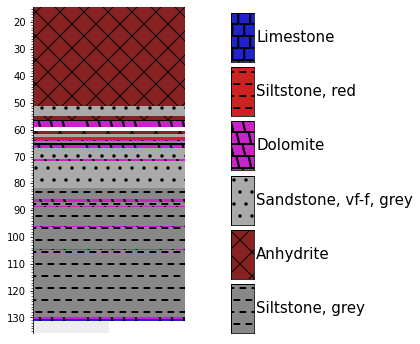

In [52]:
fix, ax = plt.subplots(ncols=2, figsize=(6,6))
bh3d.plot(legend=legend, ax=ax[0])
bh3d.legend.plot(ax=ax[1])

In [53]:
b = bh3d.intervals[0].base

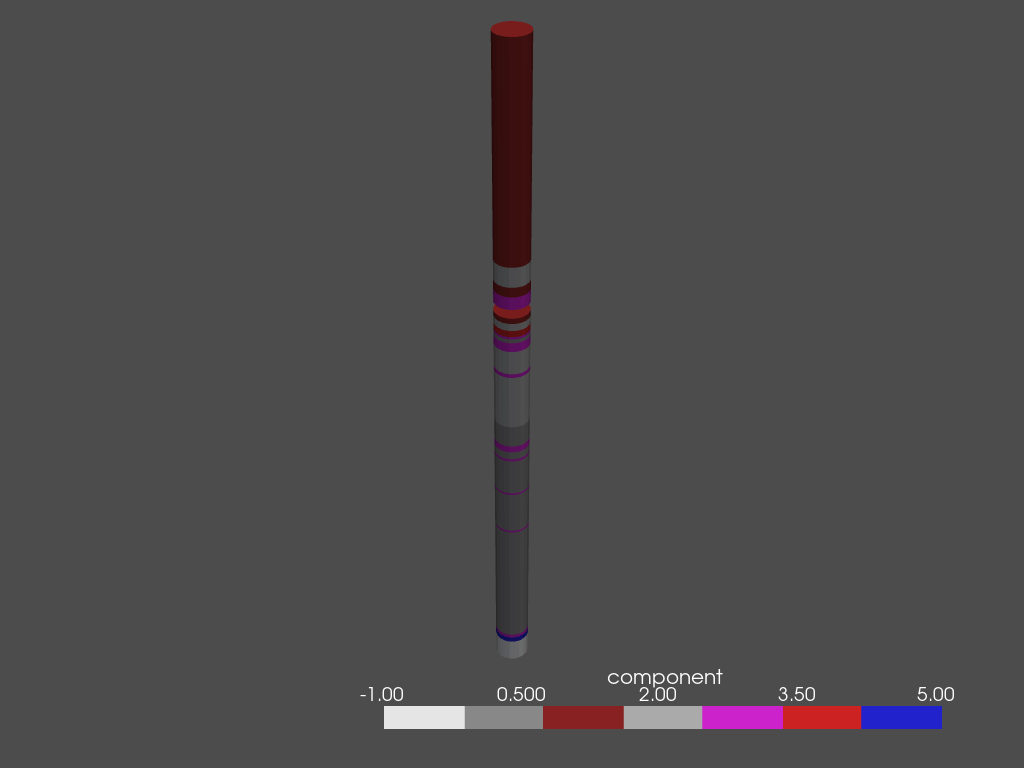

In [54]:
bh3d.plot3d()

In [55]:
def plot3d(x3d=False):
    omf_legend, omf_ = striplog_legend_to_omf_legend(bh.legend)
    pl = pv.Plotter()
    seg = ov.line_set_to_vtk(bh.geometry)
    seg.set_active_scalars('component')
    ov.lineset.add_data(seg, bh.geometry.data)
    pl.add_mesh(seg.tube(radius=3), cmap=bh.omf_cmap)
    if not x3d:
        pl.show()
    else:
        writer = vtkX3DExporter()
        writer.SetInput(pl.renderer.GetRenderWindow())
        filename = f'bh_{bh.name:s}.x3d'
        writer.SetFileName(filename)
        writer.Update()
        writer.Write()
        x3d_html = f'<html>\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n' \
                    '<title>X3D scene</title>\n <p>' \
                    '<script type=\'text/javascript\' src=\'http://www.x3dom.org/download/x3dom.js\'> </script>\n' \
                    '<link rel=\'stylesheet\' type=\'text/css\' href=\'http://www.x3dom.org/download/x3dom.css\'/>\n' \
                    '</head>\n<body>\n<p>\n For interaction, click in the view and press "a" to see the whole scene. For more info on interaction,' \
                    ' please read  <a href="https://doc.x3dom.org/tutorials/animationInteraction/navigation/index.html">the docs</a>  \n</p>\n' \
                    '<x3d width=\'968px\' height=\'600px\'>\n <scene>\n' \
                    '<viewpoint position="-1.94639 1.79771 -2.89271" orientation="0.03886 0.99185 0.12133 3.75685">' \
                    '</viewpoint>\n <Inline nameSpaceName="Borehole" mapDEFToID="true" url="'+filename+'" />\n' \
                    '</scene>\n</x3d>\n</body>\n</html>\n'
        return HTML(x3d_html)

In [56]:
bh3d.plot3d(x3d=True)

In [57]:
project = ov.load_project('omfproj.omf')

### Create the db engine and the database structure

In [58]:
engine = create_engine('sqlite:///tmp/test_orm_db.db', echo=True)

In [59]:
Base.metadata.create_all(engine)

2020-12-18 06:35:37,447 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-18 06:35:37,448 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:35:37,450 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-18 06:35:37,450 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:35:37,451 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2020-12-18 06:35:37,452 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:35:37,454 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2020-12-18 06:35:37,455 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:35:37,455 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Intervals")
2020-12-18 06:35:37,456 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:35:37,457 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Intervals")
2020-12-18 06:35:37,458 INFO sqlalchemy.engine.base.Engine ()
2020-12-18

### Create the objects from text files (las, csv, txt)

In [60]:
lexicon = Lexicon.default()

In [61]:
borehole_dict = {'F01':'../data/test.las', 'F02':'../data/test.csv'} # boreholes to insert into the db

In [68]:
def strip_from_text(files=borehole_dict): 
    #I have to finish this part by combining the to functions strip from csv and las
    #the function will choose the good script for csv or las file
    #TODO : build our own lexicon !
    strip= Striplog.from_image('../data/strip_img_test.png', 14.3, 135.9, legend=legend)
    # used this trick to avoid error with strip variable definition
    global boreholes
    
    int_id = 0
    bh_id = 0
    boreholes = []
    components = []
    comp_id = 0
    component_dict={}
    
    #---------------------------------subfunction---------------------------------------
    def file_process(filename):
        if re.compile(r".+\.las").match(filename):
            print(f"File {filename:s} OK! Creation of the striplog ...")
            with open(filename, 'r') as las3:
                strip = Striplog.from_las3(las3.read(), lexicon)
                
        elif re.compile(r".+\.(csv|txt)").match(filename):
            print(f"File {filename:s} OK! Creation of the striplog ...")
            f = re.DOTALL | re.IGNORECASE
            regex_data = r'start.+?\n(.+?)(?:\n\n+|\n*\#|\n*$)' #retrieve data of BH
            #regex_bh= r'\#.+?name\n(.+?)(?:\n\n+|\n*\#|\n*$)' #retrieve BH_name
            pattern=re.compile(regex_data, flags=f)
            with open(filename, 'r') as csv:
                text = pattern.search(csv.read()).group(1)
                text=re.sub(r'[\t]+',';', re.sub(r'(\n+|\r\n|\r)', '\n', text.strip()))
                strip=Striplog.from_descriptions(text, dlm=';',lexicon=lexicon)

        else:
            print("Error! Please check the file extension !")
            #break
        
        return strip
    #---------------------------------------------------------------

    for bh, filename in files.items():        
        file_process(filename)
            
        interval_number = 0
        boreholes.append(BoreholeOrm(id=bh))
        for c in strip.components:
            if c not in component_dict.keys():
                component_dict.update({c:comp_id})
                comp_id += 1
       
        
        d ={}
        for interval in strip:
            d.update({int_id:{'description':interval.description, 'interval_number' : interval_number}})
            interval_number+=1
            int_id += 1
        boreholes[bh_id].intervals_values = d
        bh_id += 1 
    components = {v:k for k,v in component_dict.items()} 
    
    return boreholes

In [69]:
strip_from_text()

File ../data/test.las OK! Creation of the striplog ...
File ../data/test.csv OK! Creation of the striplog ...


No match found for #ff4c4a with tolerance of 0. Best match is Siltstone, red, #cc2222, d=77.23341245859851
No match found for #ff99cc with tolerance of 0. Best match is Sandstone, vf-f, grey, #aaaaaa, d=93.11283477587824
No match found for #a6d1ff with tolerance of 0. Best match is Sandstone, vf-f, grey, #aaaaaa, d=93.60555539069249
No match found for #a1655a with tolerance of 0. Best match is Siltstone, grey, #888888, d=62.976185975335156
No match found for #a68374 with tolerance of 0. Best match is Siltstone, grey, #888888, d=36.40054944640259
No match found for #f7e9a6 with tolerance of 0. Best match is Sandstone, vf-f, grey, #aaaaaa, d=99.56907150315303
No match found for #a657fa with tolerance of 0. Best match is Dolomite, #cc22cc, d=79.8060148109151


### Create the ORM session

In [70]:
Session = sessionmaker(bind=engine)
session = Session()

### Create the ORM project

In [71]:
p = Project(session)

2020-12-18 06:36:31,089 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 06:36:31,091 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-18 06:36:31,092 INFO sqlalchemy.engine.base.Engine ()


### Add boreholes into the database

In [72]:
for bh in boreholes:
    p.add_borehole(bh)

2020-12-18 06:36:31,690 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id) VALUES (?)
2020-12-18 06:36:31,692 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-18 06:36:31,695 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description) VALUES (?, ?, ?, ?)
2020-12-18 06:36:31,695 INFO sqlalchemy.engine.base.Engine ((0, 'F01', 0, ''), (1, 'F01', 1, ''), (2, 'F01', 2, ''), (3, 'F01', 3, ''), (4, 'F01', 4, ''), (5, 'F01', 5, ''), (6, 'F01', 6, ''), (7, 'F01', 7, '')  ... displaying 10 of 26 total bound parameter sets ...  (24, 'F01', 24, ''), (25, 'F01', 25, ''))
2020-12-18 06:36:31,697 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-18 06:36:31,891 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 06:36:31,893 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-18 06:36:31,894 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 06:36:31,898 INFO sqlalchemy.engine.base.En

In [73]:
p.boreholes[0].id

'F01'

In [74]:
p.boreholes[1].id='F33'

In [75]:
p.boreholes[1].id

'F33'

In [76]:
p.commit()

2020-12-18 06:36:33,772 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET id=? WHERE "Boreholes".id = ?
2020-12-18 06:36:33,773 INFO sqlalchemy.engine.base.Engine ('F33', 'F02')
2020-12-18 06:36:33,775 INFO sqlalchemy.engine.base.Engine COMMIT


In [77]:
p.boreholes[0].intervals[0].description

2020-12-18 06:36:34,175 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 06:36:34,176 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2020-12-18 06:36:34,177 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-18 06:36:34,180 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2020-12-18 06:36:34,181 INFO sqlalchemy.engine.base.Engine ('F01',)


''

In [78]:
session.close()

2020-12-18 06:36:34,587 INFO sqlalchemy.engine.base.Engine ROLLBACK


### Test linking orm and omf : 
For now IntervalOrm do not have a base and a top -> adding them to the intervals retrieved from the boreholes in the sqlite database

In [79]:
bh3d.intervals[0].base.z


51.24117647058824

In [80]:
itvls = list(p.boreholes[0].intervals.values())

In [81]:
z=0.
dz=10.
itvls_list = []
for itvl in itvls:
    comp = Component(lexicon.get_component(itvl.description))
    top = Position(x=0., y=10., middle=z)
    z += dz
    base = Position(x=0., y=10., middle=z)
    itvls_list.append(Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon))

In [82]:
bh3d.intervals[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': 'Anhydrite', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]})

In [83]:
itv = Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon)

In [84]:
itv

Interval({'top': Position({'middle': 250.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'base': Position({'middle': 260.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({})]})

In [85]:
type(bh3d.intervals[0])

striplog.interval.Interval

In [86]:
bh3d_2 = Borehole3D(itvls_list)

Borehole geometry created successfully !


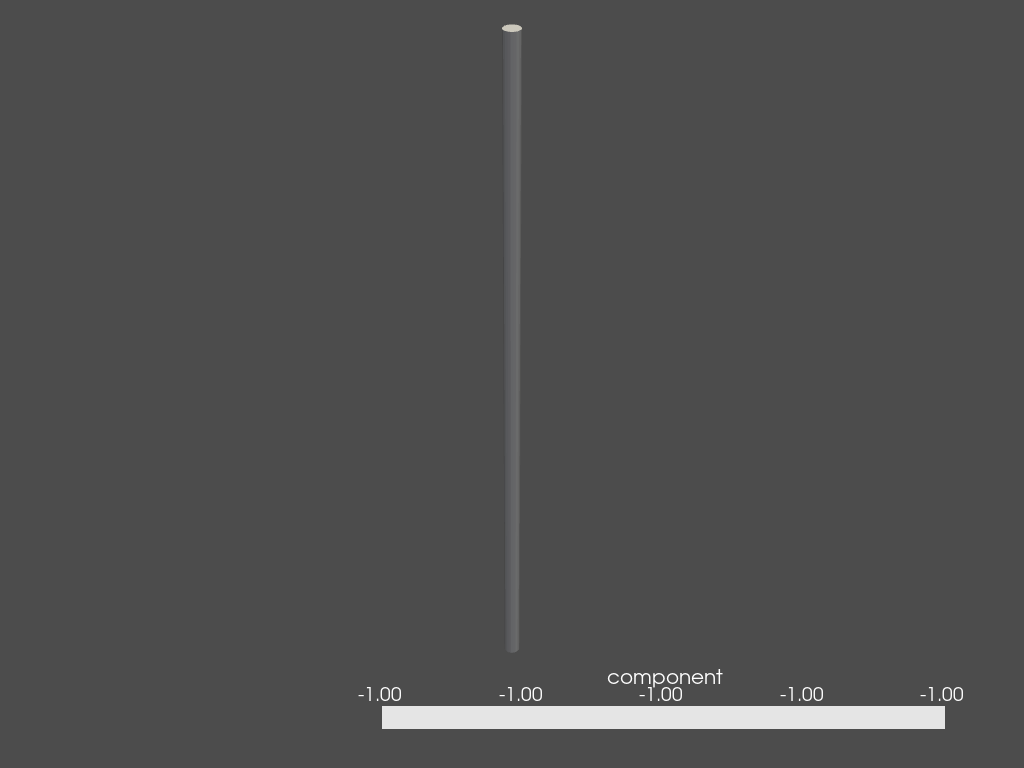

In [87]:
bh3d_2.plot3d()